In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
if os.path.join(os.getcwd(), "..") not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), ".."))

In [3]:
# !pip install -q -r ../requirements.dev.txt

## Imports & Functions

In [22]:
# system lib
import os
from datetime import datetime
from typing import Dict, List

        
# import python packages  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm.auto import tqdm

  
# import local packages
from src.constant import Chain
from src.token import Token
from src.utils import print_log
from utils import (
    CacheUtils, 
    DataUtils, 
    ProcessingUtils, 
    Utility,
    VisualizeUtils,
    CAMPAIGN_START_DATETIME
)

# load dotenv
if load_dotenv():
    print_log(".env file loaded")
    
CHAINS = [
    Chain.ARBITRUM_ONE, Chain.OPTIMISM, 
    Chain.BNB_CHAIN, Chain.POLYGON, Chain.GNOSIS]
    
LATEST_DATE = datetime.strptime("2023-04-19 14:00:00", "%Y-%m-%d %H:%M:%S")

.env file loaded


## Load Data

In [5]:
for chain in CHAINS:
    CacheUtils.save_cache(chain, reload=False)

dataset = DataUtils.load_dataset(CHAINS)

Cache already existed!
Cache already existed!
Cache already existed!
Cache already existed!
Cache already existed!
Cache loaded successfully!
Data loaded from chain arbitrum_one, total of 23783 record
Cache loaded successfully!
Data loaded from chain optimism, total of 6229 record
Cache loaded successfully!
Data loaded from chain bnb_chain, total of 3436 record
Cache loaded successfully!
Data loaded from chain polygon, total of 13522 record
Cache loaded successfully!
Data loaded from chain gnosis, total of 2152 record


## Analysis

In [53]:
LP_TOKENS = [Token.CWETHLP, Token.CUSDCLP]
MIN_VALUE = 0.0001
TIMEFRAME = "1T" # 1 minutes
THRESHOLD = 0.3

Arbitrum_one


Analyzing users in Arbitrum_one:   0%|          | 0/13584 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/13584 [00:00<?, ?it/s]

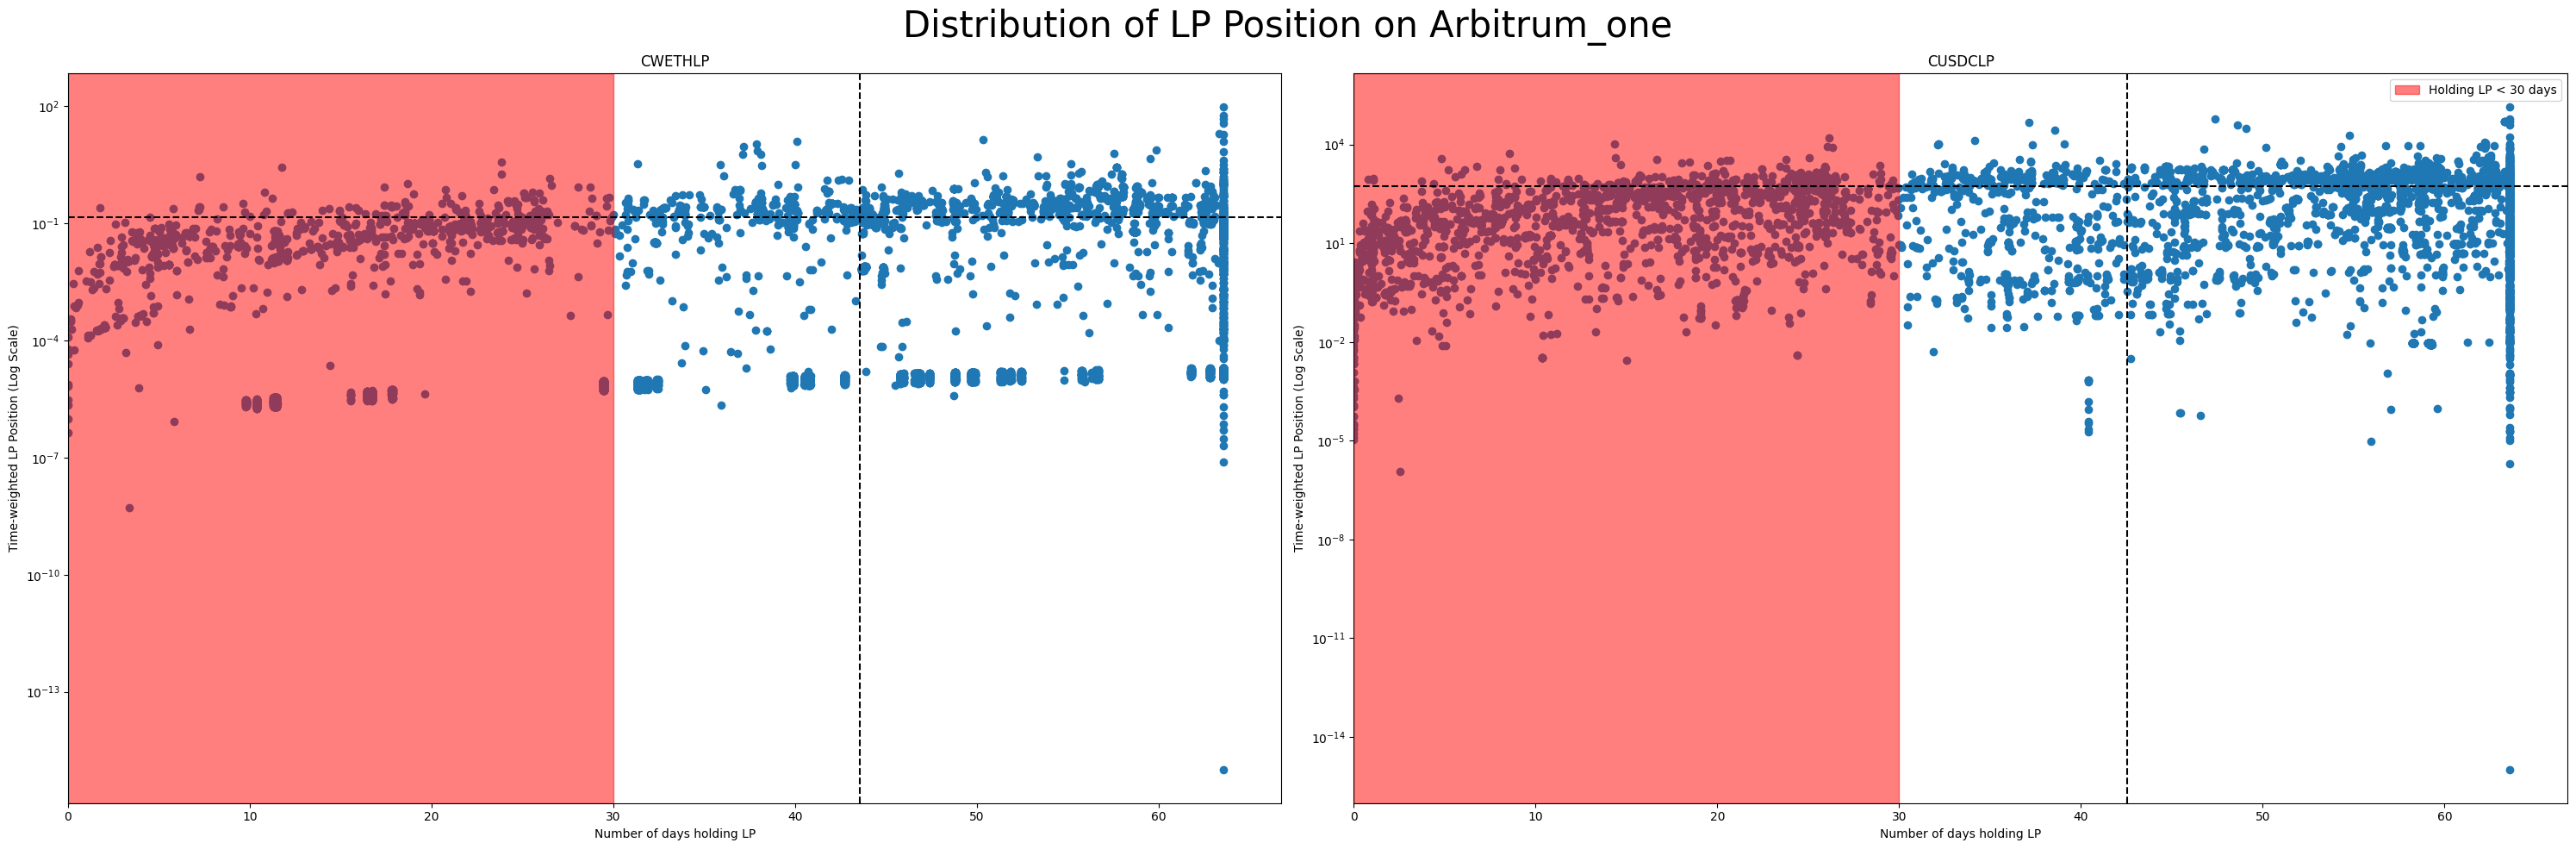

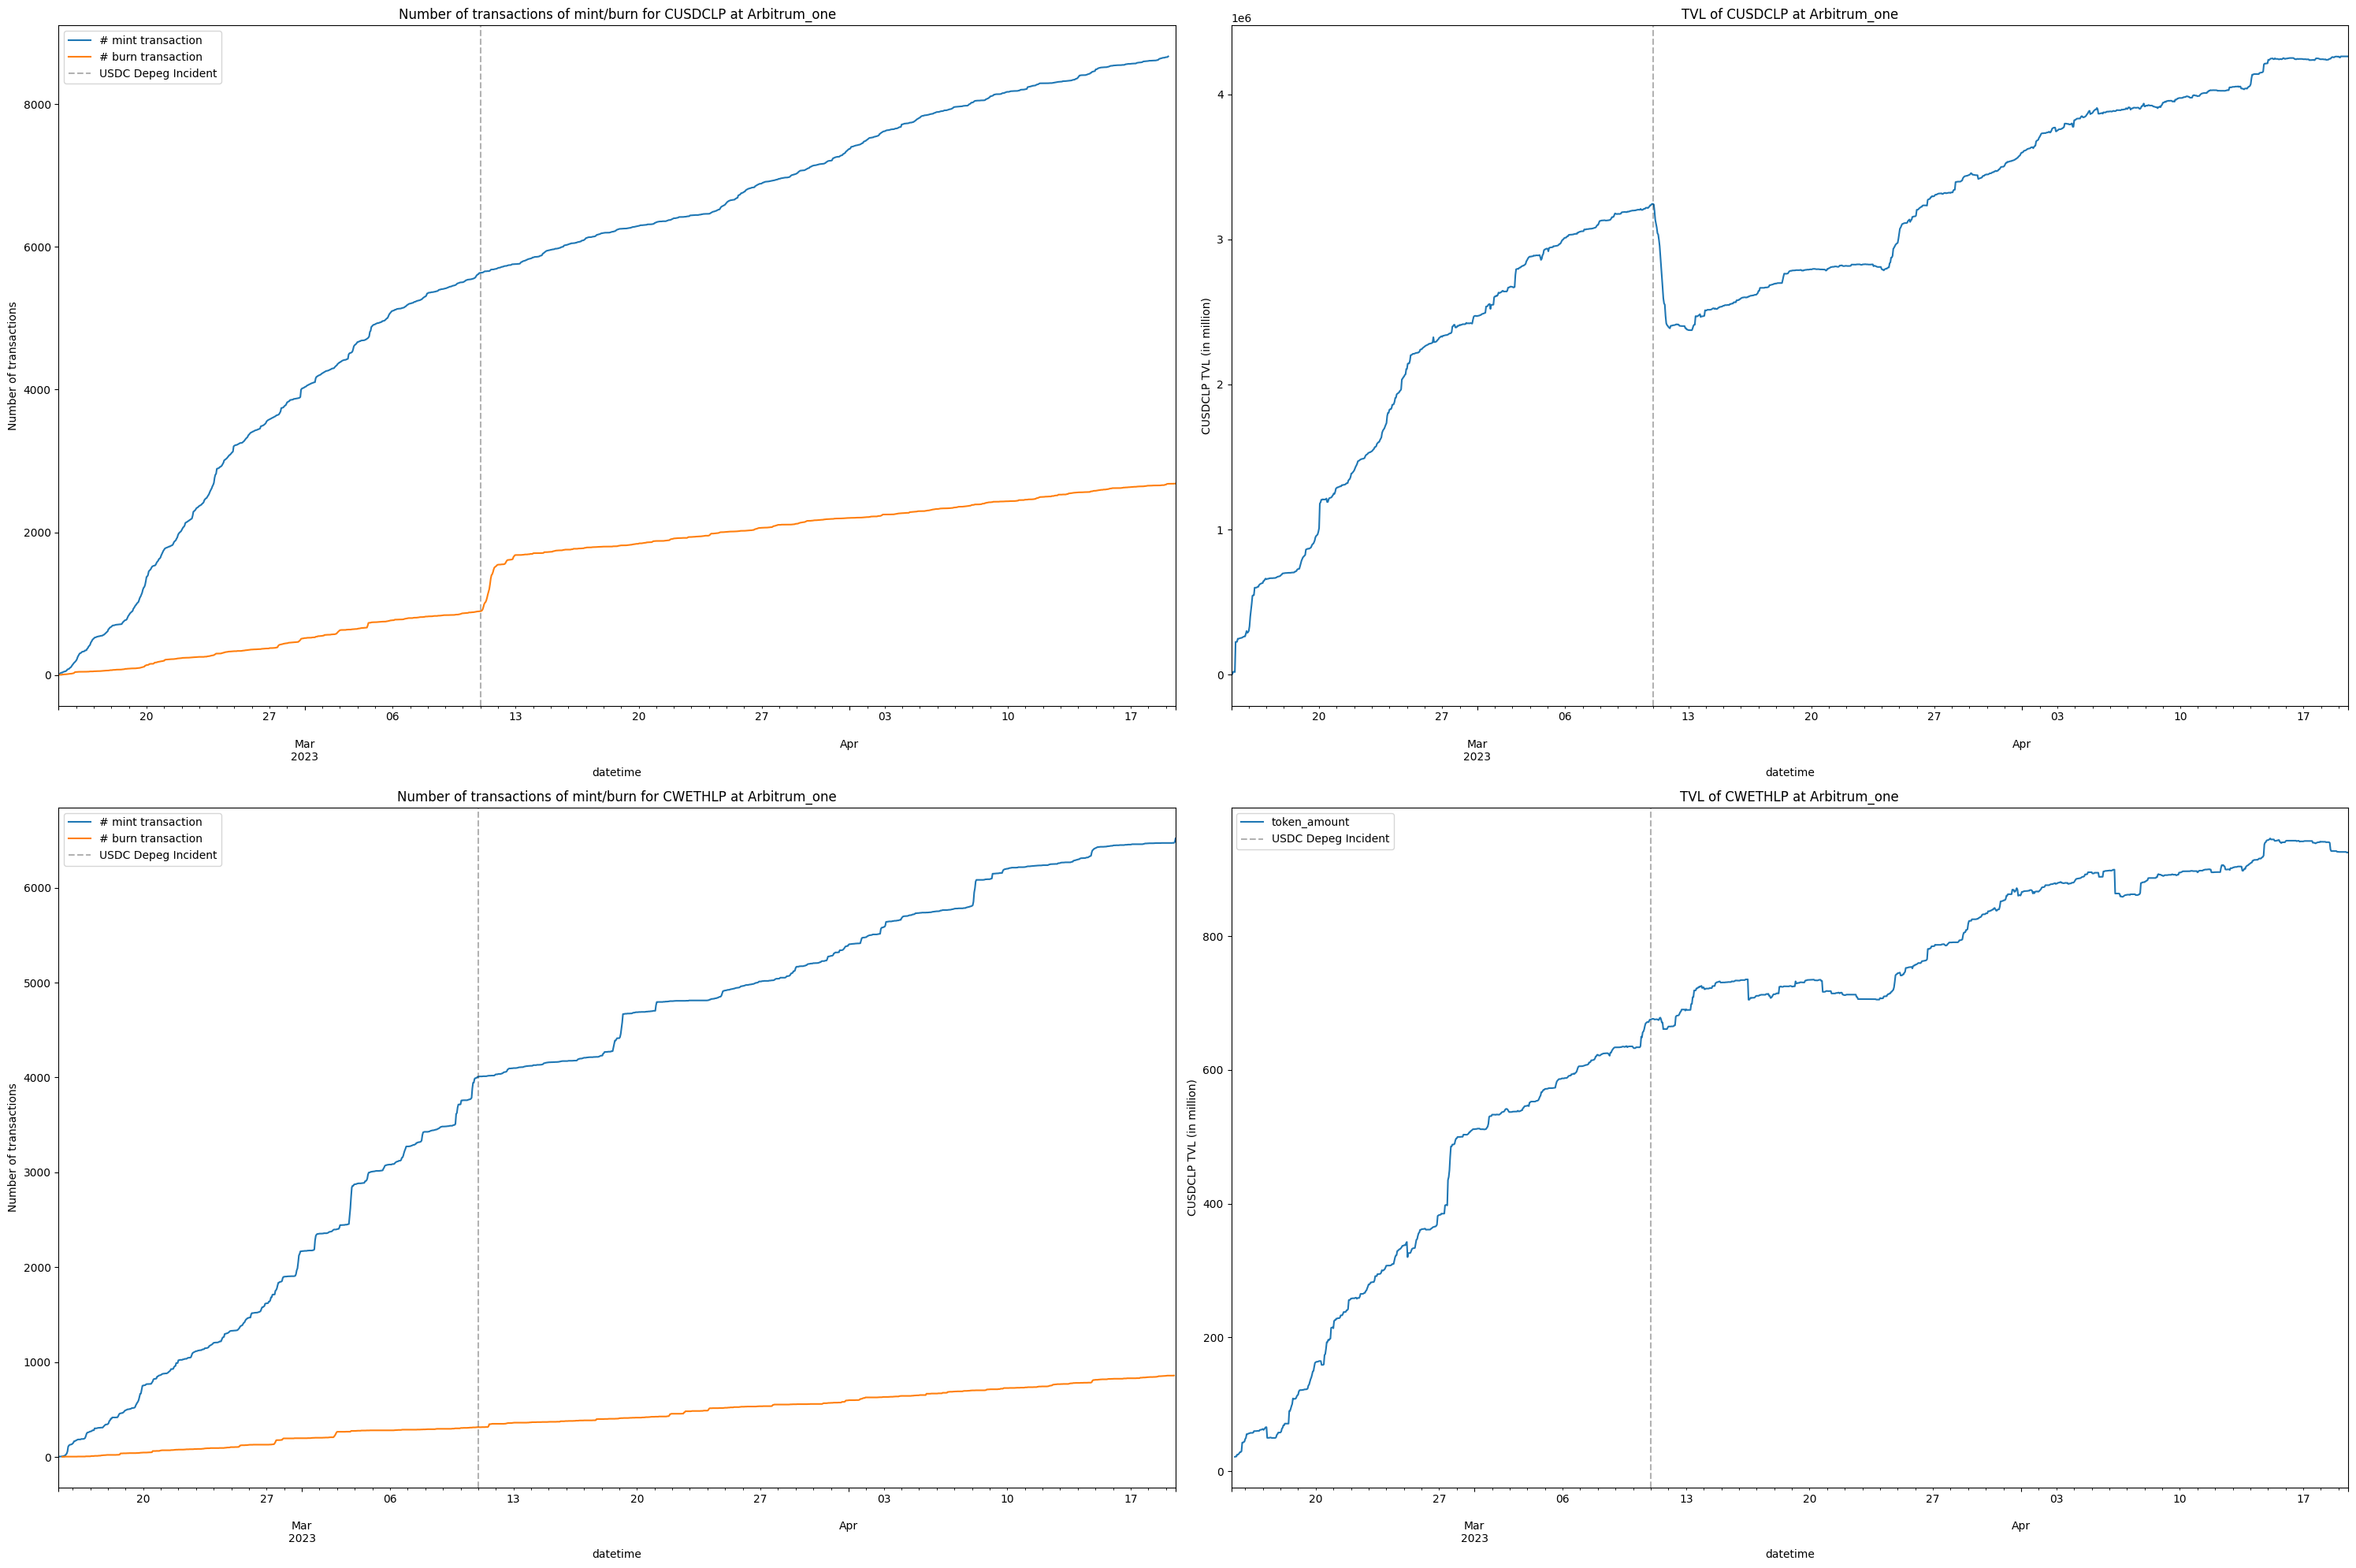

Number of users holding CWETHLP: 7661
Number of users holding CUSDCLP: 6650
Total of CWETHLP Add Liquidity tx: 8580
Total of CWETHLP Remove Liquidity tx: 923
Total of CUSDCLP Add Liquidity tx: 11124
Total of CUSDCLP Remove Liquidity tx: 3002
Number of qualified USDC LP Provider: 1995 / 6650
Minimum qualified score: 458.2045
Number of qualified WETH LP Provider: 2298 / 7661
Minimum qualified score: 0.0711

Optimism


Analyzing users in Optimism:   0%|          | 0/2728 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/2728 [00:00<?, ?it/s]

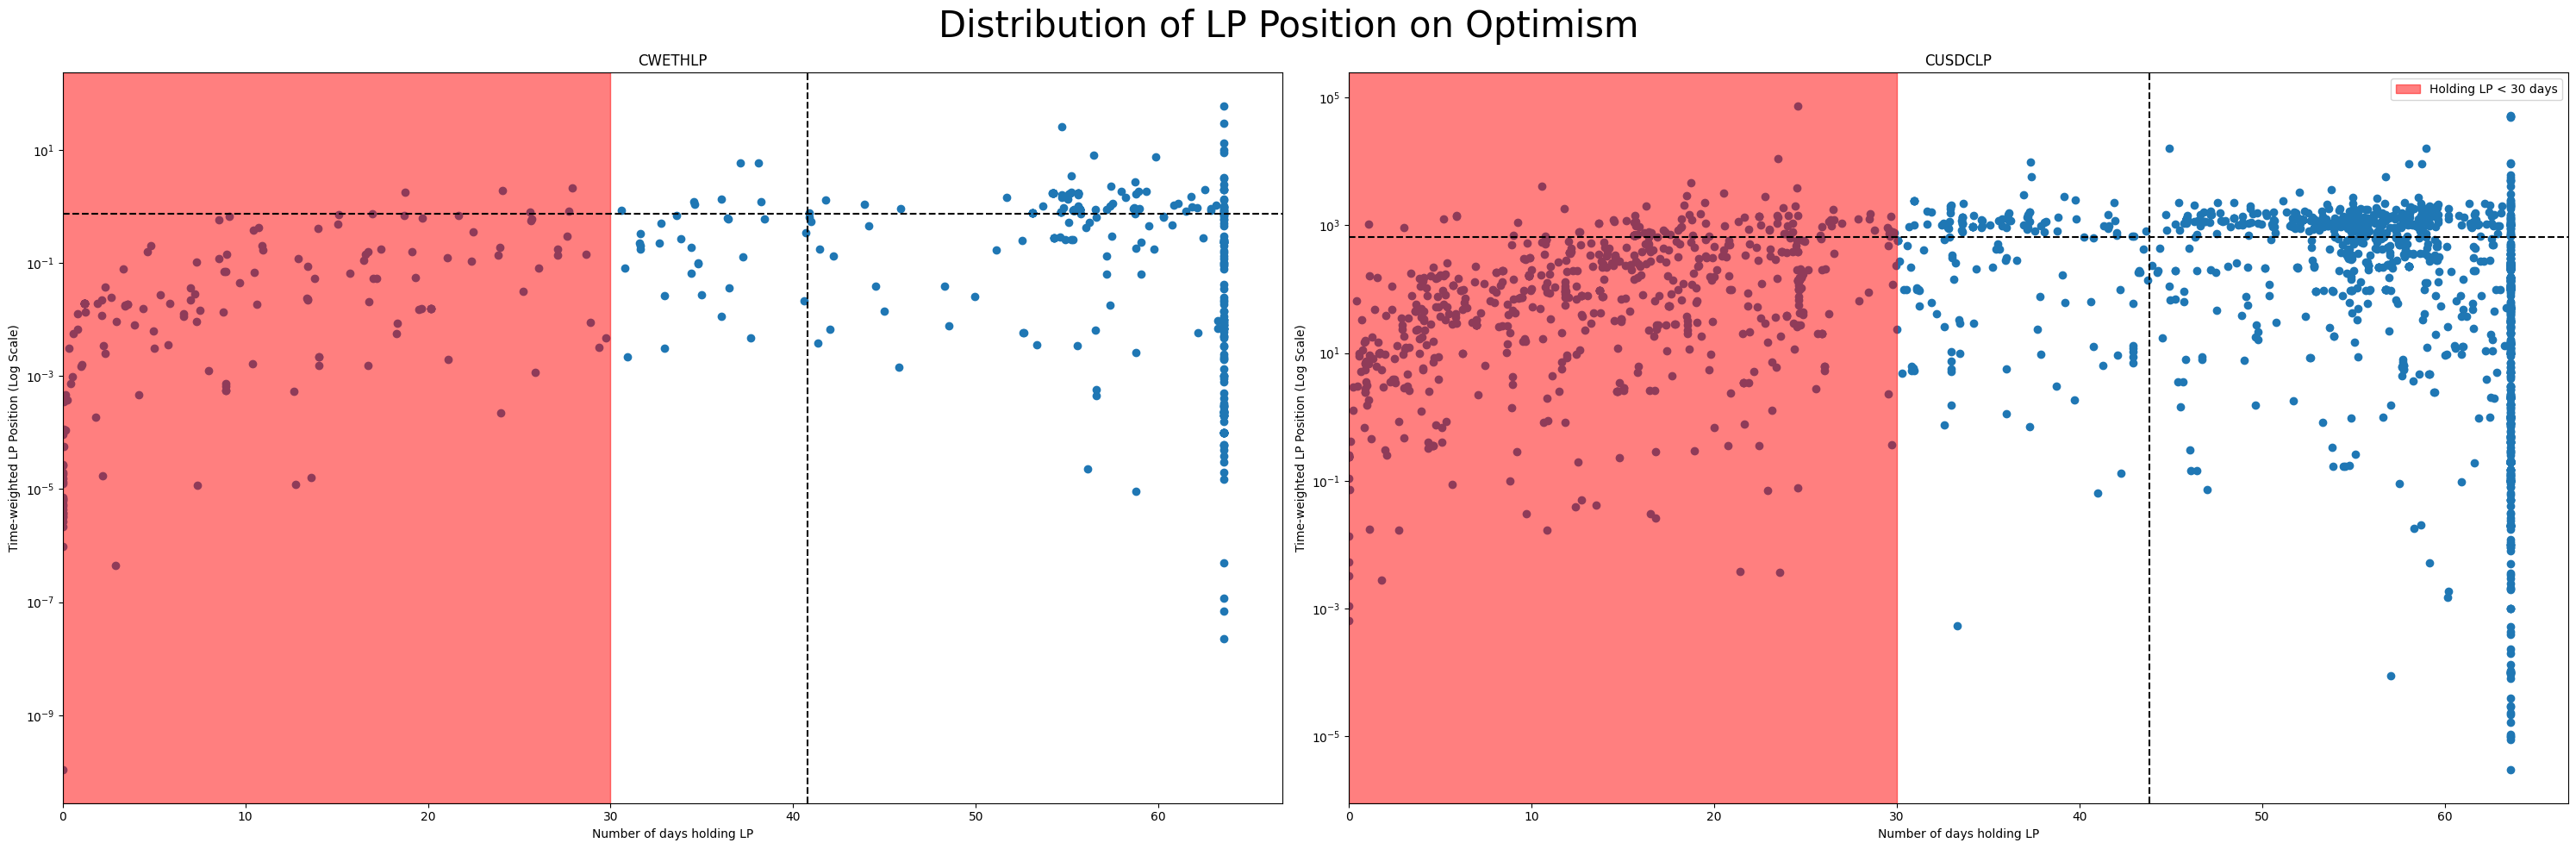

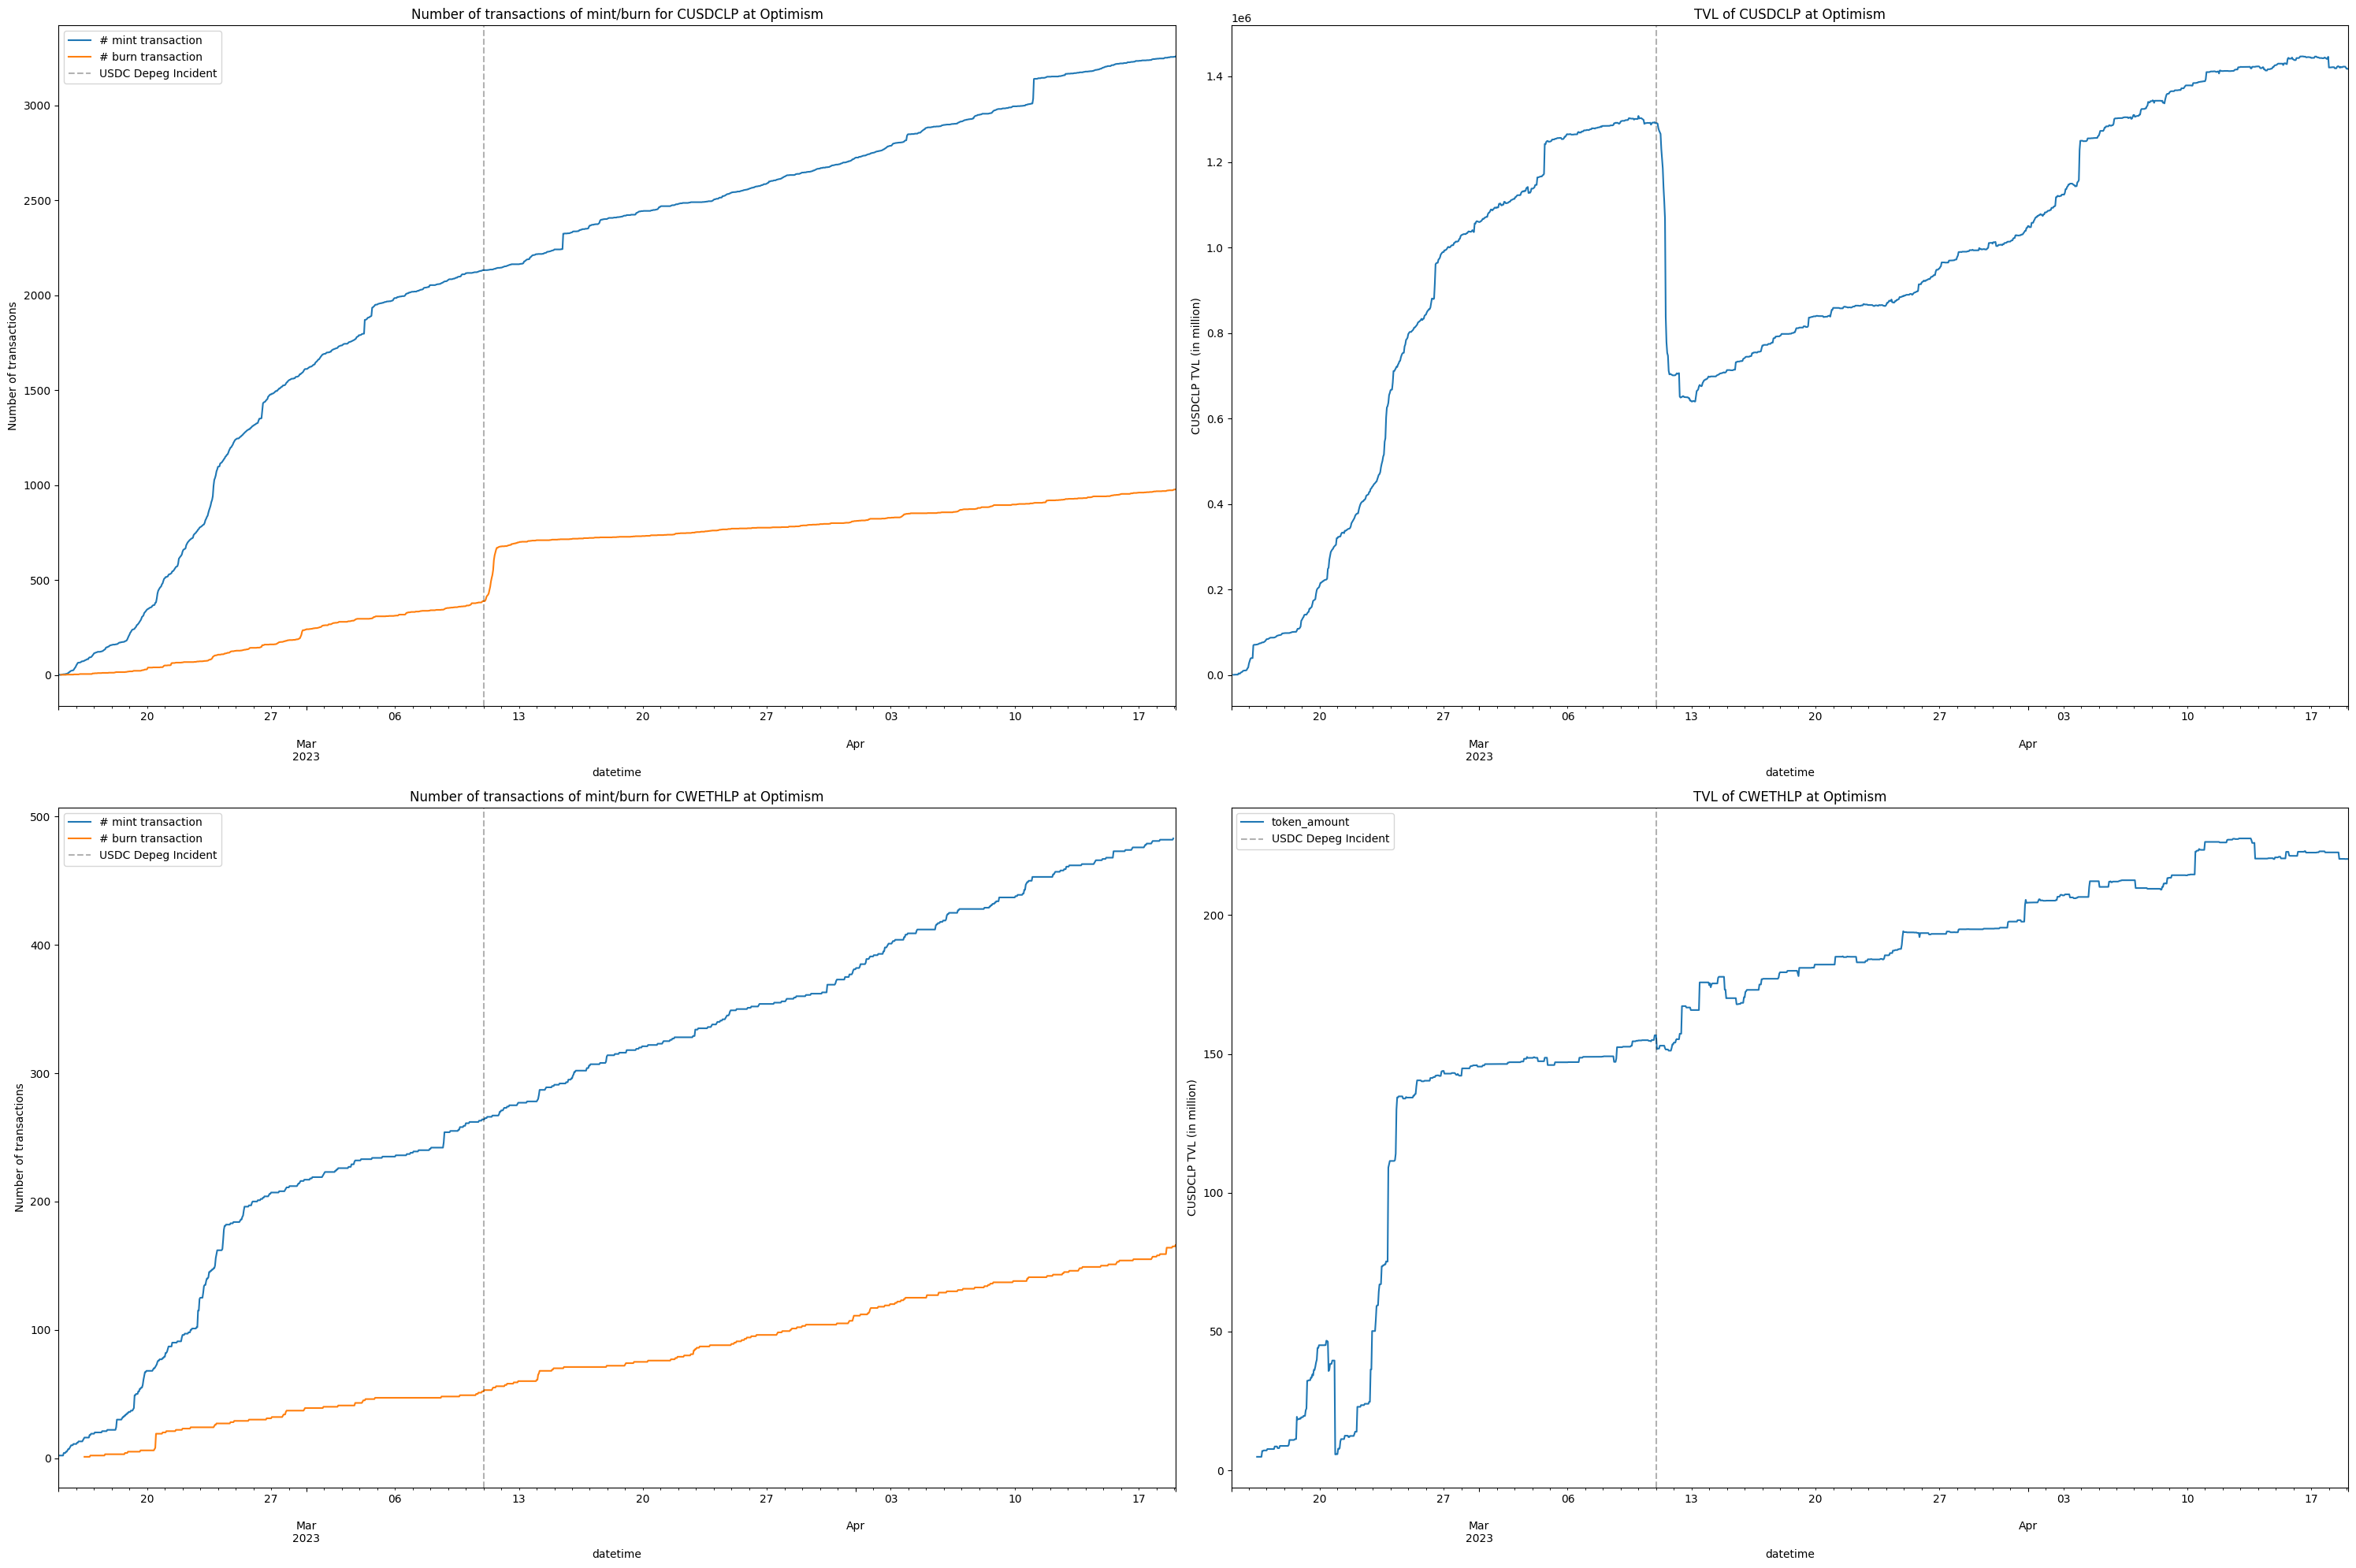

Number of users holding CWETHLP: 489
Number of users holding CUSDCLP: 2375
Total of CWETHLP Add Liquidity tx: 661
Total of CWETHLP Remove Liquidity tx: 183
Total of CUSDCLP Add Liquidity tx: 4149
Total of CUSDCLP Remove Liquidity tx: 1073
Number of qualified USDC LP Provider: 712 / 2375
Minimum qualified score: 799.2775
Number of qualified WETH LP Provider: 147 / 489
Minimum qualified score: 0.5927

Bnb_chain


Analyzing users in Bnb_chain:   0%|          | 0/1563 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/1563 [00:00<?, ?it/s]

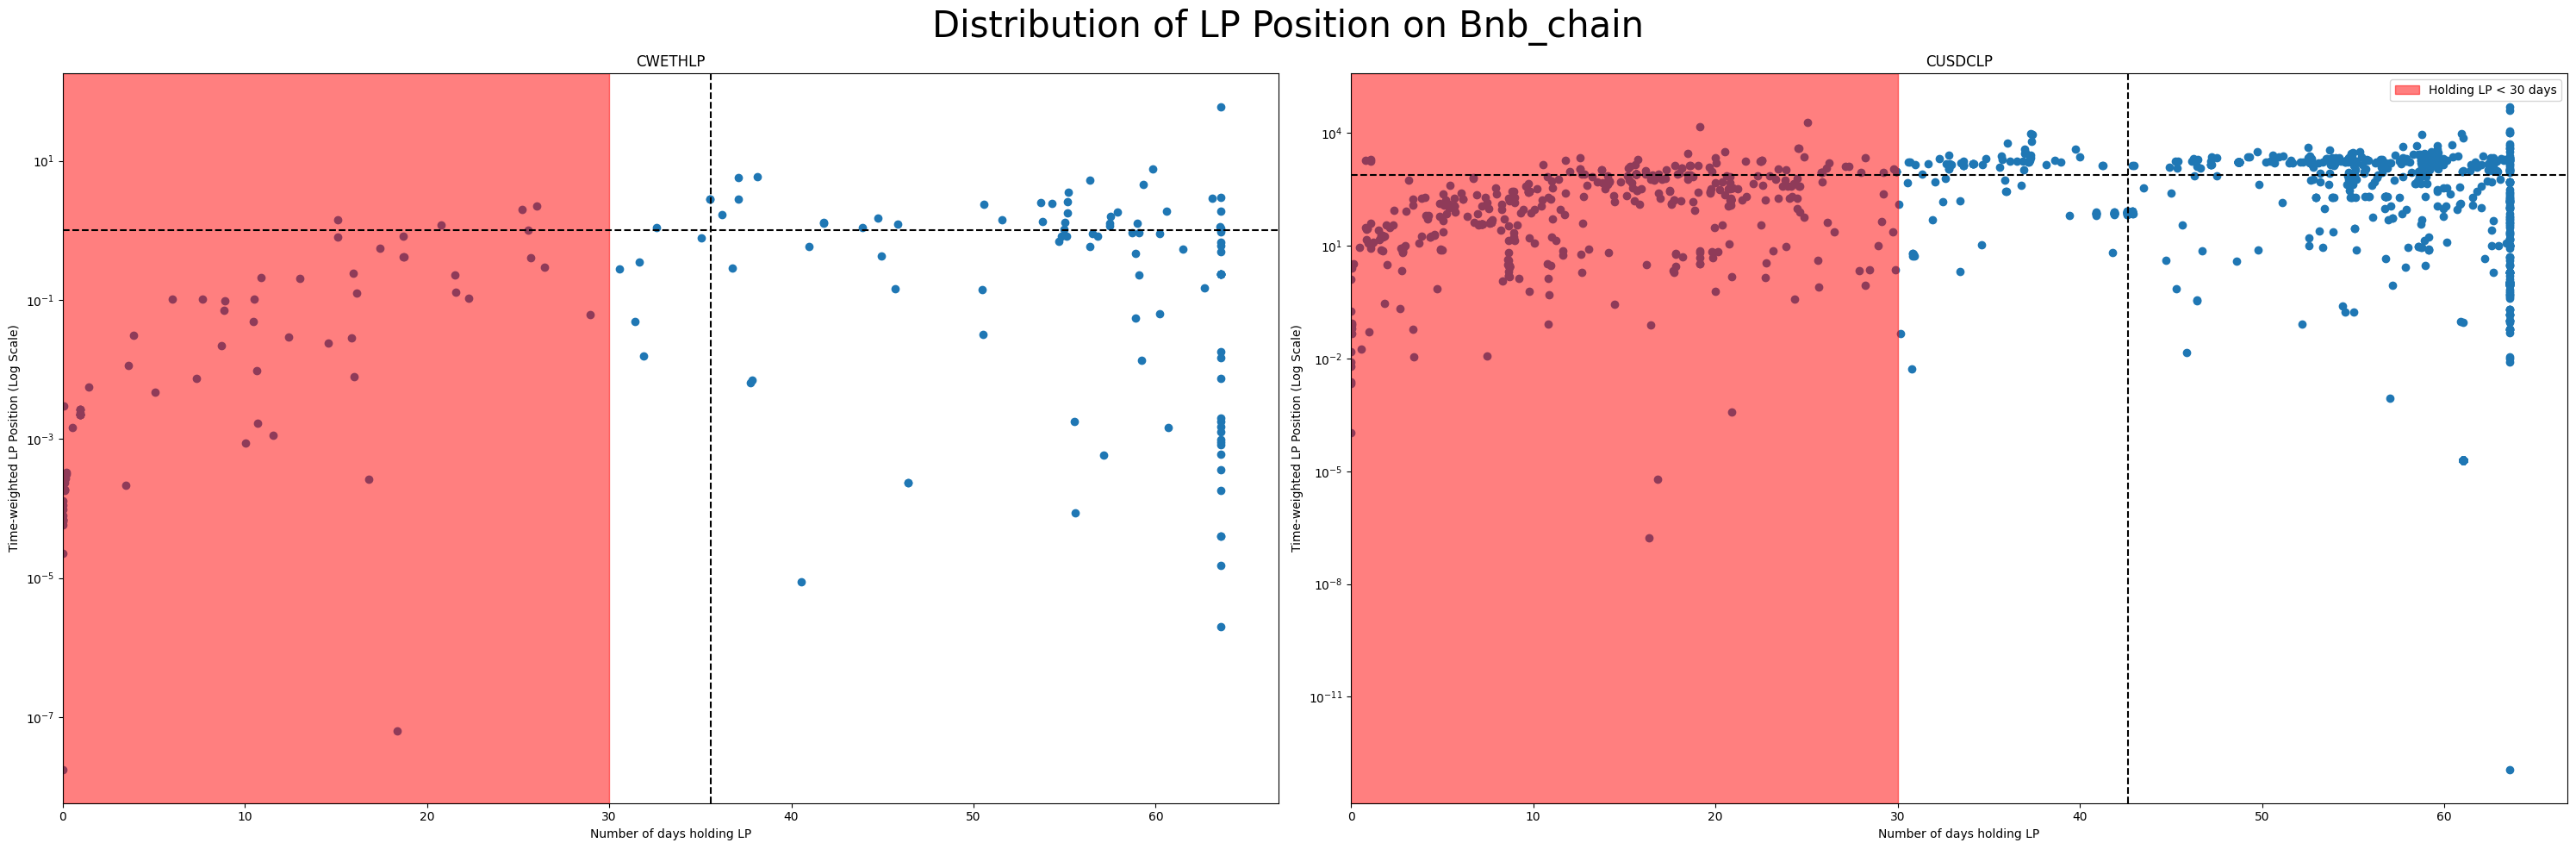

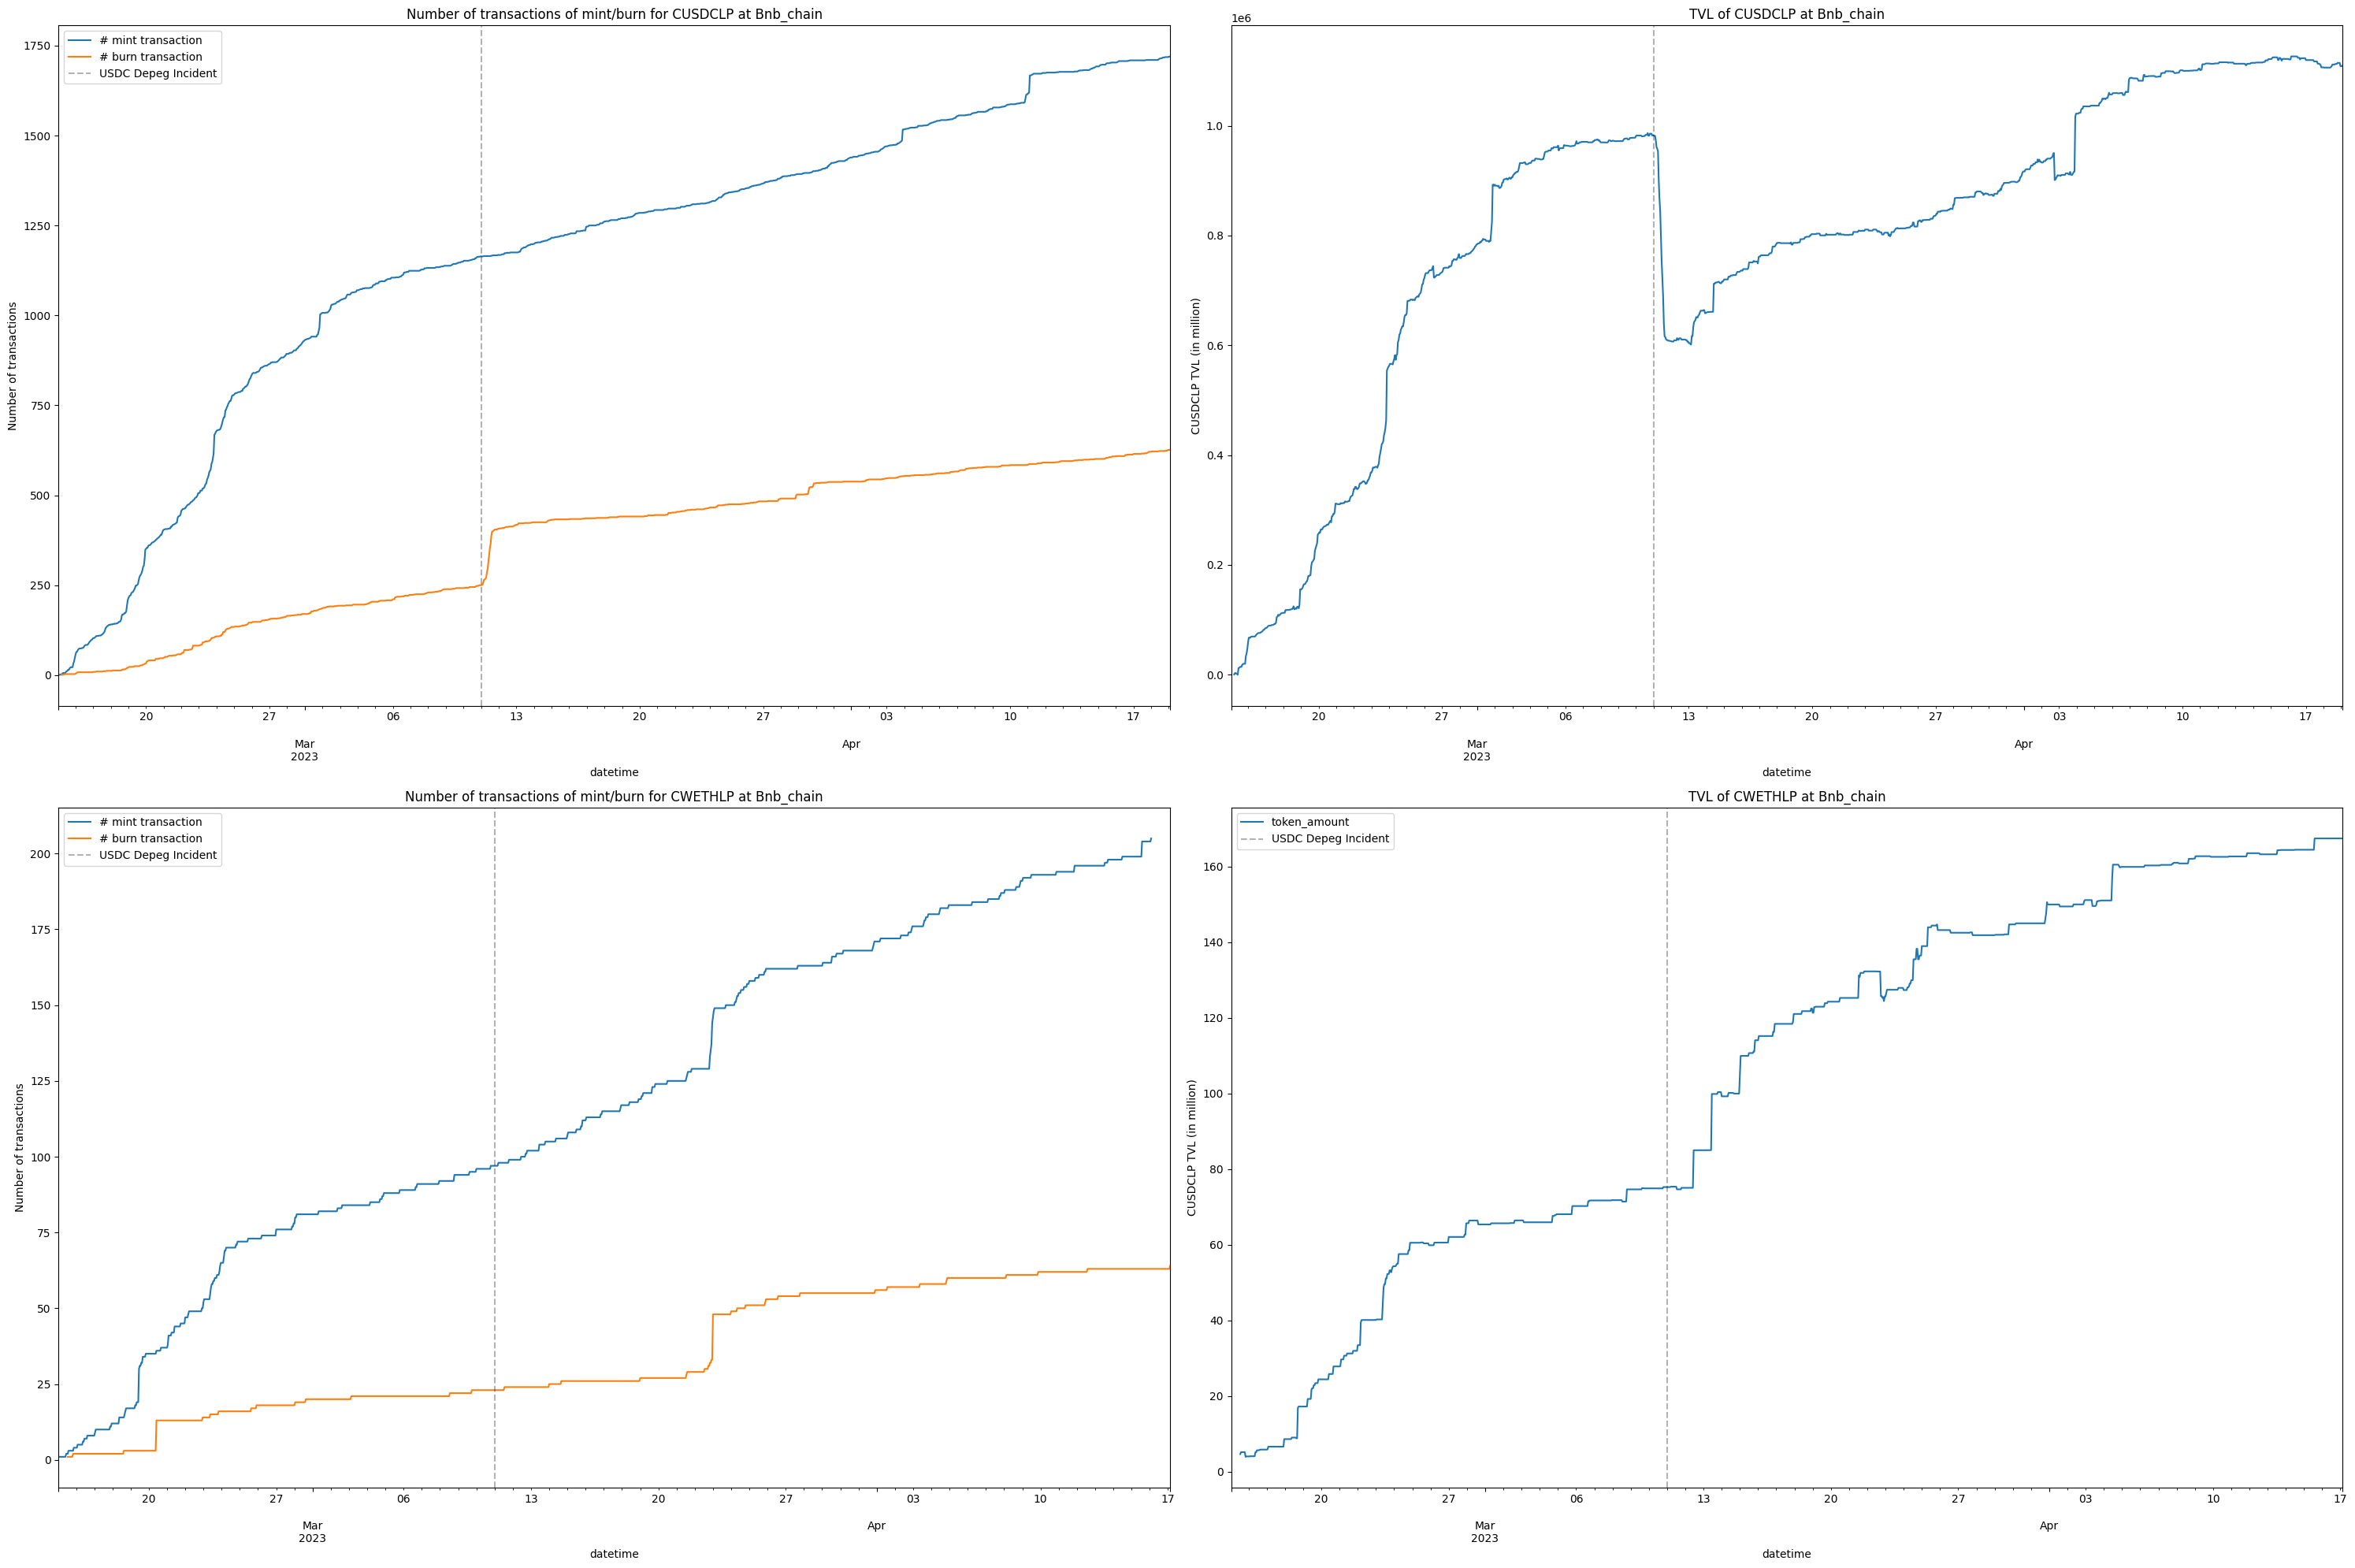

Number of users holding CWETHLP: 176
Number of users holding CUSDCLP: 1422
Total of CWETHLP Add Liquidity tx: 245
Total of CWETHLP Remove Liquidity tx: 67
Total of CUSDCLP Add Liquidity tx: 2074
Total of CUSDCLP Remove Liquidity tx: 677
Number of qualified USDC LP Provider: 427 / 1422
Minimum qualified score: 956.6424
Number of qualified WETH LP Provider: 53 / 176
Minimum qualified score: 0.8004

Polygon


Analyzing users in Polygon:   0%|          | 0/5726 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/5726 [00:00<?, ?it/s]

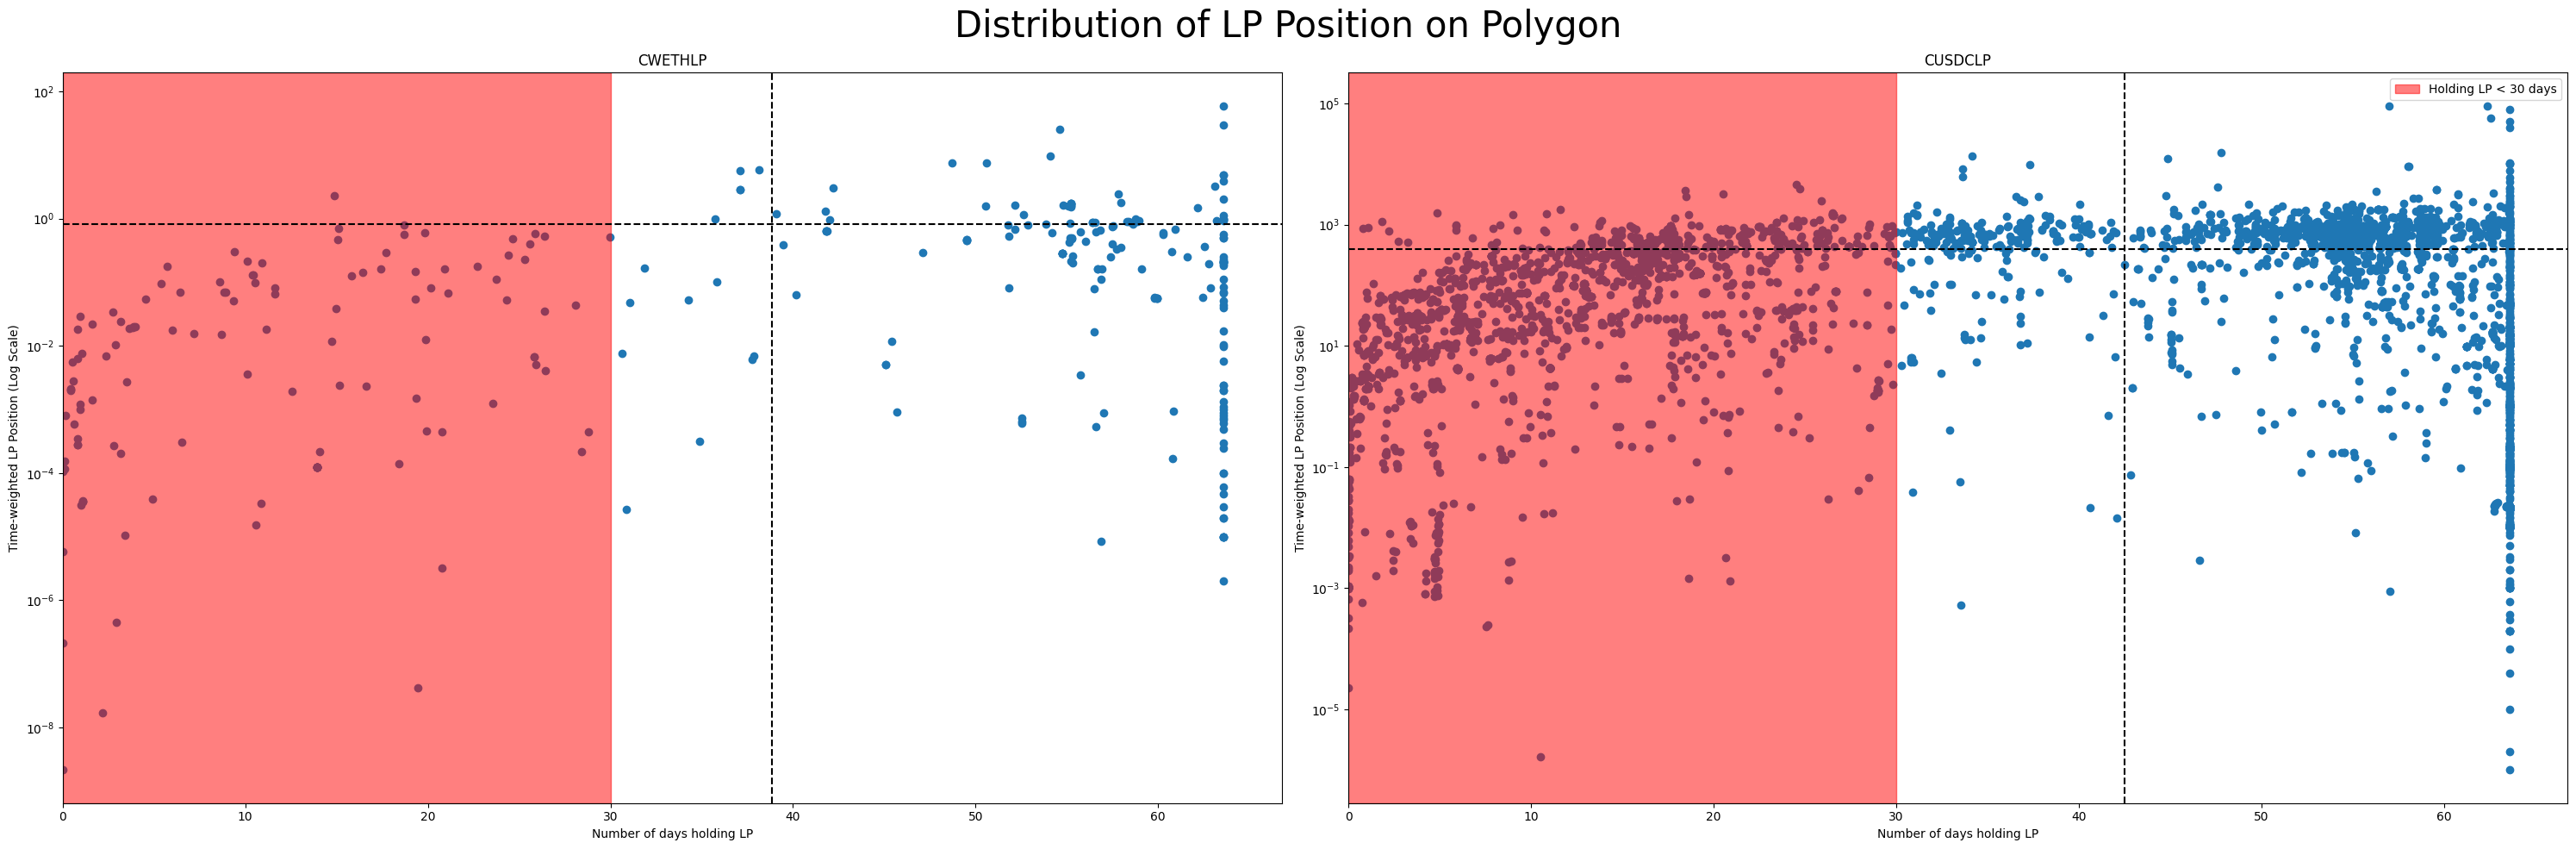

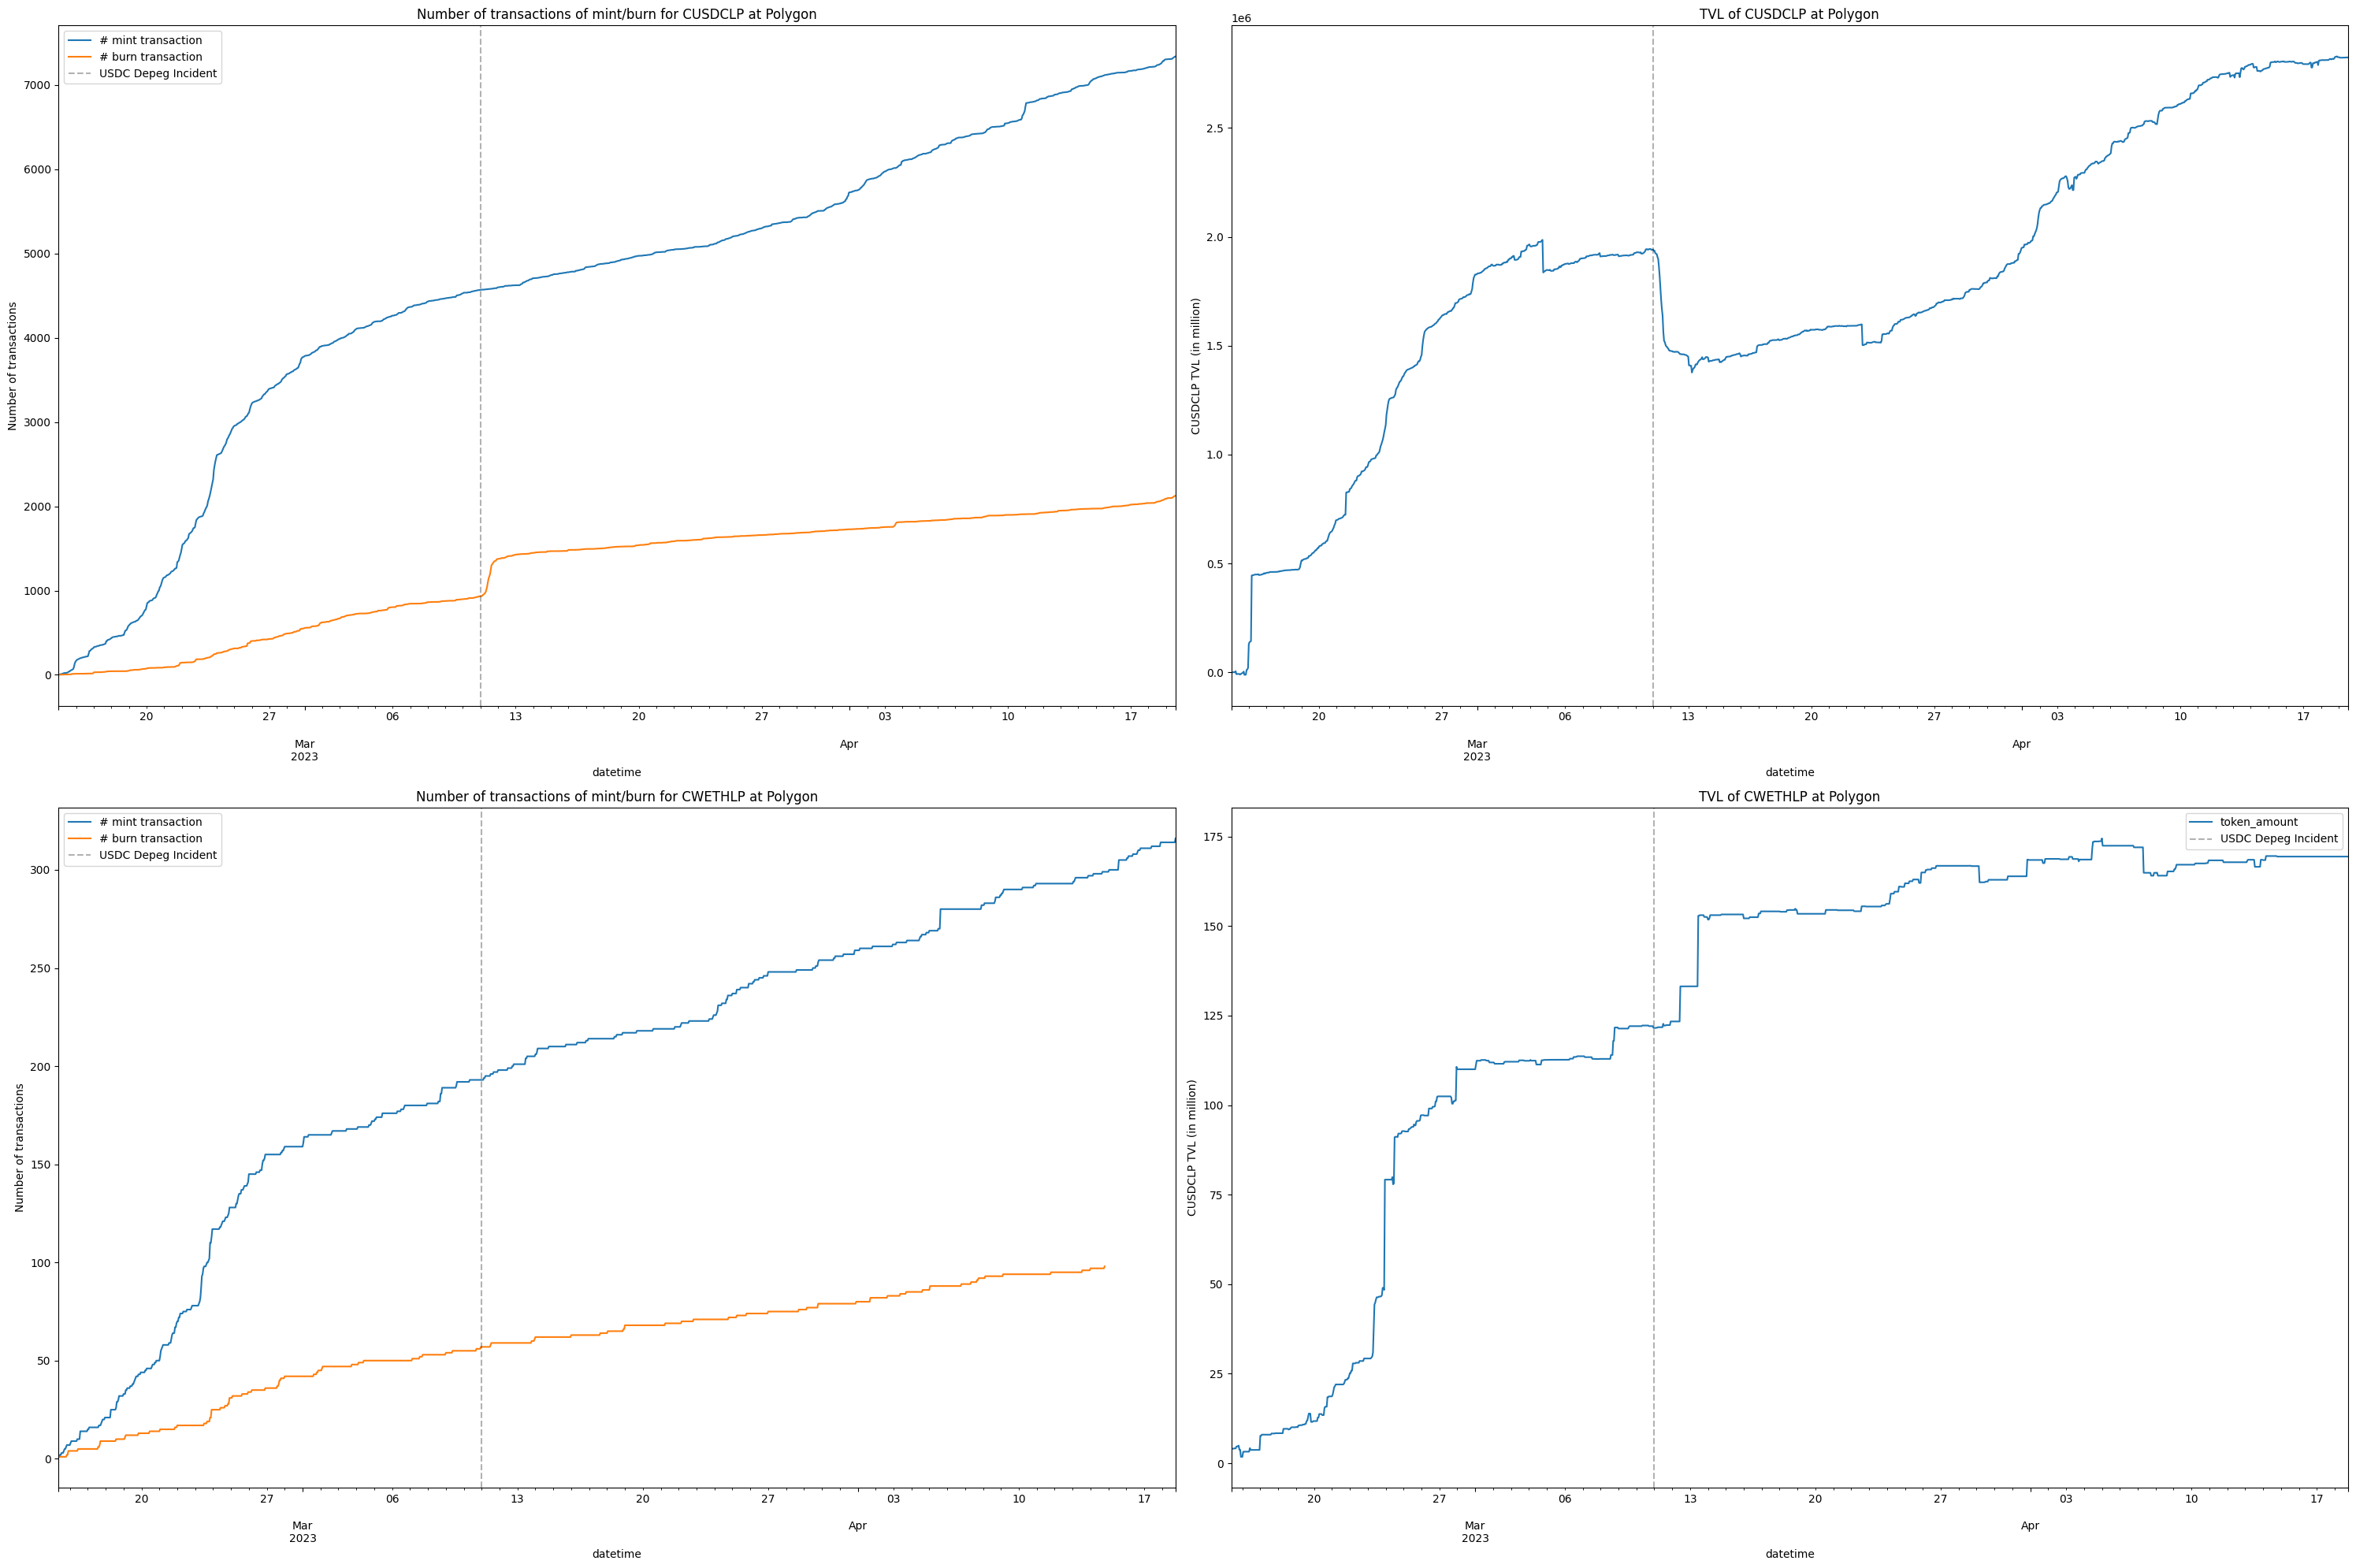

Number of users holding CWETHLP: 318
Number of users holding CUSDCLP: 5505
Total of CWETHLP Add Liquidity tx: 406
Total of CWETHLP Remove Liquidity tx: 108
Total of CUSDCLP Add Liquidity tx: 10385
Total of CUSDCLP Remove Liquidity tx: 2248
Number of qualified USDC LP Provider: 1652 / 5505
Minimum qualified score: 428.1218
Number of qualified WETH LP Provider: 95 / 318
Minimum qualified score: 0.3619

Gnosis


Analyzing users in Gnosis:   0%|          | 0/1263 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/1263 [00:00<?, ?it/s]

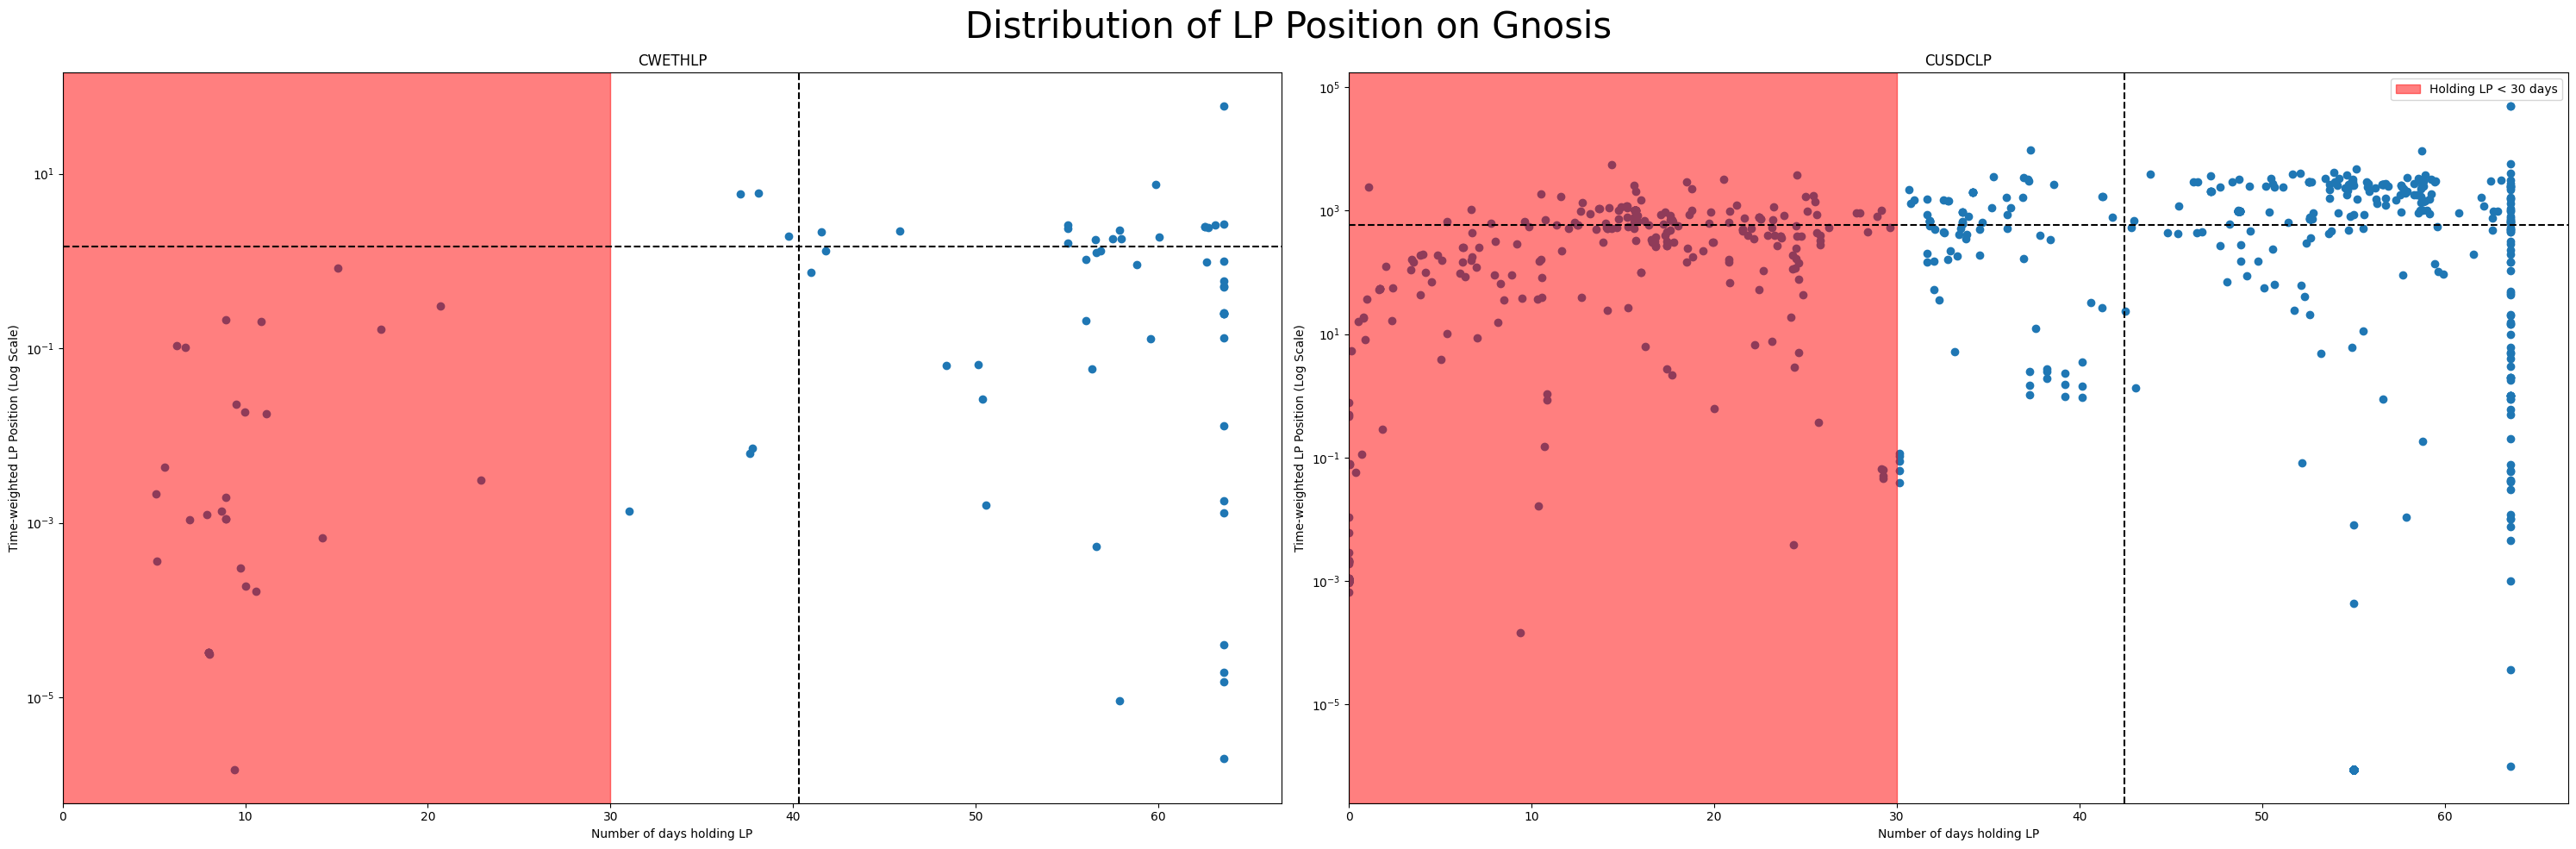

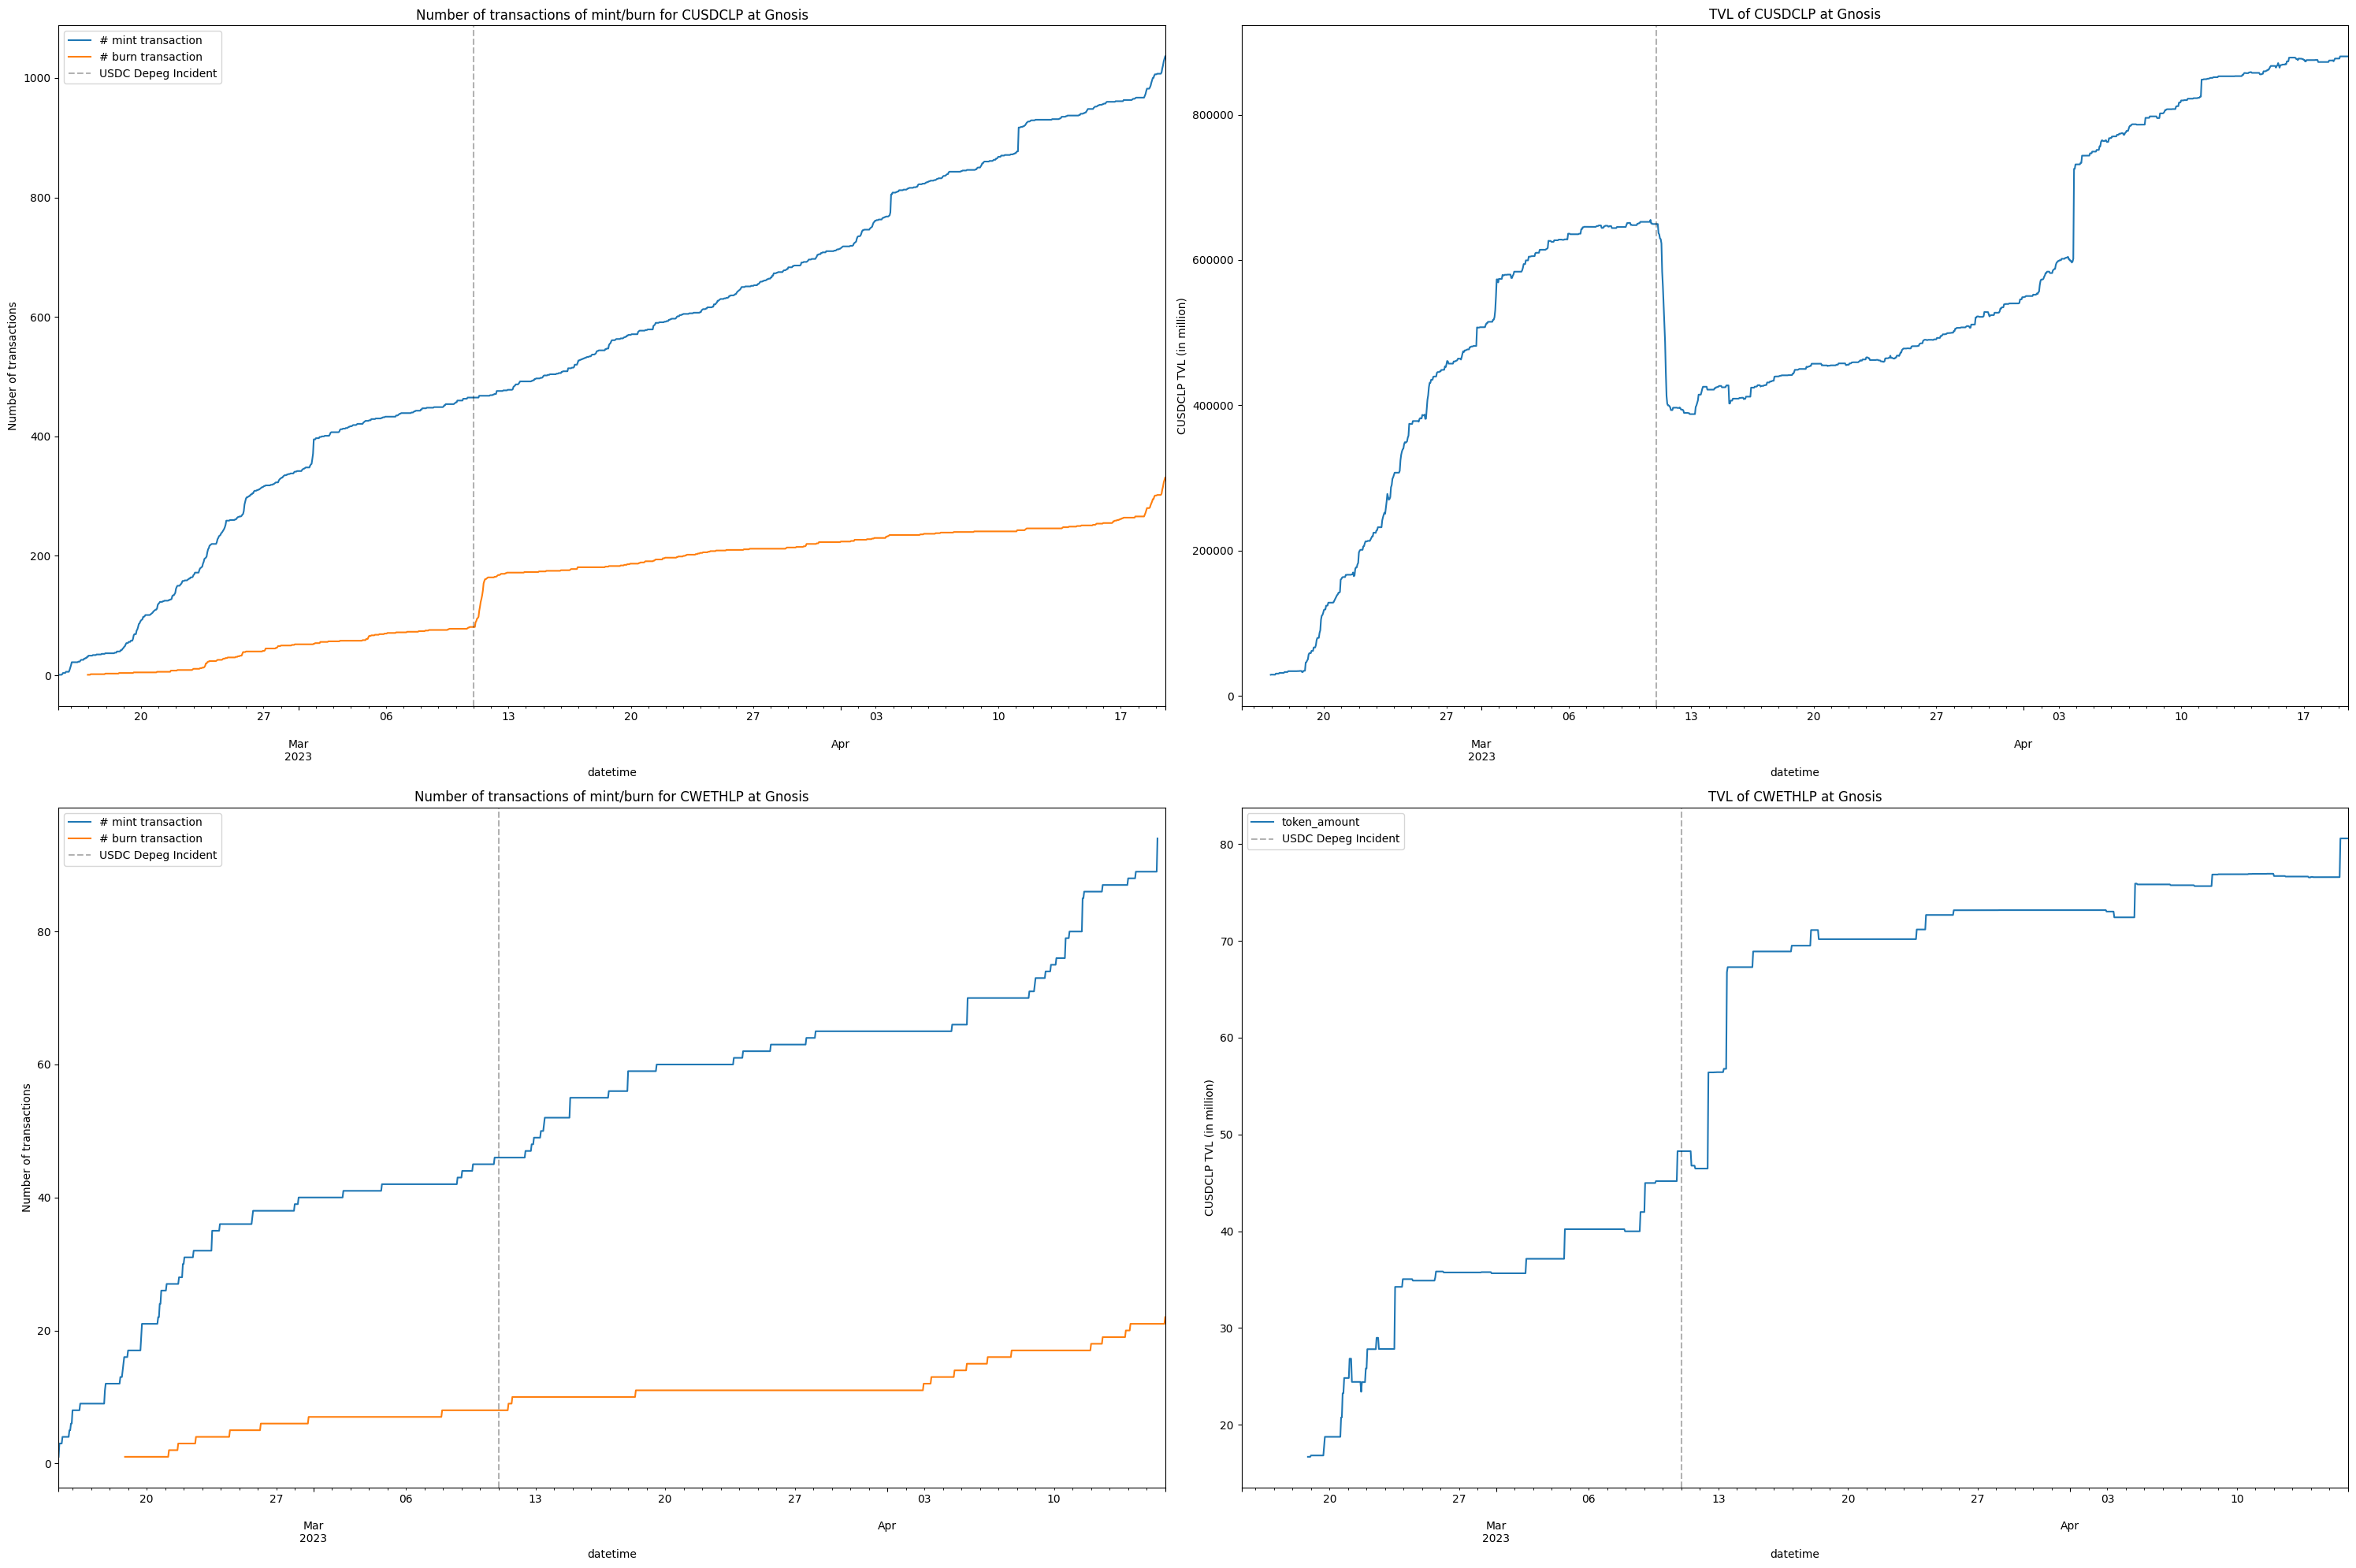

Number of users holding CWETHLP: 87
Number of users holding CUSDCLP: 1204
Total of CWETHLP Add Liquidity tx: 125
Total of CWETHLP Remove Liquidity tx: 26
Total of CUSDCLP Add Liquidity tx: 1149
Total of CUSDCLP Remove Liquidity tx: 346
Number of qualified USDC LP Provider: 361 / 1204
Minimum qualified score: 508.7097
Number of qualified WETH LP Provider: 26 / 87
Minimum qualified score: 0.9821



In [80]:
for chain in CHAINS:
    
    print(f"="*20)
    print(f"{Chain.resolve_connext_domain(chain).capitalize()}")
    print(f"="*20)

    # calculate statistics
    user_txs = ProcessingUtils.get_user_txs(
        dataset=dataset,
        chain=chain,
        latest_date=LATEST_DATE,
    )

    user_infos = {
        _user: {
            _token: ProcessingUtils.process_user_balance(
                user_tx=user_txs[_user][_token],
                latest_date=LATEST_DATE,
                timeframe=TIMEFRAME,
                min_lp_value=MIN_VALUE,
            ) for _token in LP_TOKENS
            if _token in user_txs[_user]
        } for _user in tqdm(user_txs, "Processing User info")
    }

    # visualization
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    for i, token in enumerate(LP_TOKENS):
        elapsed_days = [_user[token]["elapsed_days"] for _user in user_infos.values() if token in _user]
        twa_balance = [_user[token]["twa_balance"] for _user in user_infos.values() if token in _user]

        ax[i].scatter(elapsed_days, twa_balance)
        ax[i].axvline(np.mean(elapsed_days), linestyle="--", color="black")
        ax[i].axhline(np.mean(twa_balance), linestyle="--", color="black")
        ax[i].set_yscale("log")

        ax[i].axvspan(0, 30, alpha=0.5, color='red', label="Holding LP < 30 days")
        ax[i].set_xlim(left=0)
        ax[i].set_xlabel("Number of days holding LP")
        ax[i].set_ylabel("Time-weighted LP Position (Log Scale)")
        ax[i].set_title(f"{token}")

    fig.suptitle(f"Distribution of LP Position on {Chain.resolve_connext_domain(chain).capitalize()}", fontsize=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

    VisualizeUtils.visualize_lps(dataset, chain)

    for token in LP_TOKENS:
        print(f"Number of users holding {token}: {len([_user for _user in user_txs.values() if token in _user])}")

    for token in LP_TOKENS:
        num_mint = 0
        num_burn = 0
        for _user, txs in user_txs.items():
            if token not in txs:
                continue
            num_mint += len(txs[token][txs[token]["action"] == "mint"])
            num_burn += len(txs[token][txs[token]["action"] == "burn"])

        print(f"Total of {token} Add Liquidity tx: {num_mint}")
        print(f"Total of {token} Remove Liquidity tx: {num_burn}")

    # text statistics
    usdc_lp_txs = {_user: _txs[Token.CUSDCLP] for _user, _txs in user_infos.items() if Token.CUSDCLP in _txs}
    weth_lp_txs = {_user: _txs[Token.CWETHLP] for _user, _txs in user_infos.items() if Token.CWETHLP in _txs}

    top_usdc_scores = [_u for _u, _ in sorted(usdc_lp_txs.items(), key=lambda x: x[1]["twa_balance"], reverse=True)]
    top_weth_scores = [_u for _u, _ in sorted(weth_lp_txs.items(), key=lambda x: x[1]["twa_balance"], reverse=True)]

    qualified_usdc_users = top_usdc_scores[:round(THRESHOLD * len(top_usdc_scores))]
    qualified_weth_users = top_weth_scores[:round(THRESHOLD * len(top_weth_scores))]

    print(f"Number of qualified USDC LP Provider: {len(qualified_usdc_users)} / {len(top_usdc_scores)}")
    print(f"Minimum qualified score: {usdc_lp_txs[qualified_usdc_users[-1]]['twa_balance']:.4f}")
    print(f"Number of qualified WETH LP Provider: {len(qualified_weth_users)} / {len(top_weth_scores)}")
    print(f"Minimum qualified score: {weth_lp_txs[qualified_weth_users[-1]]['twa_balance']:.4f}")
    
    print()

## Sybil Analysis

In [ ]:
token = Token.CUSDCLP
transfer_only_users = [
    (k, v[Token.CUSDCLP]) 
    for k, v in user_txs.items() 
    if (
        (len(set(v[token]["action"].unique().tolist()) - {"transfer_in", "transfer_out"}) == 0) and \
        len(v[token]) > 0
    )]